This files contains an example of tuning a Random Forest model with BayesSearchCV

It saves the BayesSearchCV object to the `cross-validation.pkl`

In [2]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

%matplotlib inline

# Load Data

In [6]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [7]:
hlp.pandas.numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,760,40,5.0%,0,0.0%,21.0,11.7,0.6,1.0,0.6,4.0,9.0,12.0,18.0,24.0,36.0,60.0
credit_amount,800,0,0.0%,38,5.0%,"3,203.9","2,932.3",0.9,1.9,3.9,0.0,753.9,"1,300.8","2,236.5","3,951.5","7,394.6","18,424.0"
installment_commitment,800,0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,800,0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,800,0,0.0%,0,0.0%,35.6,11.4,0.3,1.0,0.7,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,800,0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,800,0,0.0%,0,0.0%,1.1,0.3,0.3,2.0,2.1,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [8]:
hlp.pandas.non_numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,763,37,4.6%,no checking,4,0.5%
credit_history,800,0,0.0%,existing paid,5,0.6%
purpose,800,0,0.0%,radio/tv,10,1.2%
savings_status,800,0,0.0%,<100,5,0.6%
employment,800,0,0.0%,1<=X<4,5,0.6%
personal_status,800,0,0.0%,male single,4,0.5%
other_parties,800,0,0.0%,none,3,0.4%
property_magnitude,800,0,0.0%,car,4,0.5%
other_payment_plans,800,0,0.0%,none,3,0.4%
housing,800,0,0.0%,own,3,0.4%


In [9]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [11]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

# Transformation Pipeline

In [12]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [13]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [14]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling', hlp.sklearn_pipeline.TransformerChooser()),
])

In [15]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.TransformerChooser()),
])

In [16]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [18]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [19]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('impute',
                                                   TransformerChooser()),
                                                  ('scaling',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
     

# GridSearchCV

In [23]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [24]:
param_grad = [
    {
        'prep__numeric__impute__transformer': [SimpleImputer(strategy='mean')],
        'prep__numeric__scaling__transformer': [MinMaxScaler(), StandardScaler()],
        'prep__non_numeric__encoder__transformer': [OneHotEncoder(),
                                                    hlp.sklearn_pipeline.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [25]:
num_folds = 5
num_repeats = 2

In [26]:
new_param_column_names = {'model | max_features': 'max_features',
                          'model | n_estimators': 'n_estimators',
                          'prep | non_numeric | encoder | transformer': 'encoder',
                          'prep | numeric | impute | transformer': 'imputer',
                          'prep | numeric | scaling | transformer': 'scaler'}

In [28]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds,
                                            n_repeats=num_repeats,
                                            random_state=2),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                           )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=2),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          TransformerChooser()),
                                                                                         ('scaling',
                                                                                          TransformerChooser())]),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'installment_commitment',
                                                                          'residence_since

In [31]:
grid_search.cv_results_

{'mean_fit_time': array([10.69086976, 17.11820896, 13.22514493,  2.77584367,  7.49455621,
        17.99047174, 13.48573396, 15.59588344, 10.55500965,  6.58887012,
         0.11257358,  7.91069274,  8.04134972,  8.27588856,  0.1817301 ,
         4.39734609,  0.30114903,  8.85574732,  7.87541976,  8.06003151,
         7.82113645, 14.33602085,  7.58120205,  8.74398541,  7.50500736,
         0.14375048,  4.36607311,  7.54426692,  7.72519586,  3.96943223]),
 'std_fit_time': array([2.85190133, 3.54377803, 2.76385956, 0.55743176, 1.59113935,
        3.9489119 , 2.88849945, 3.61214214, 2.00955333, 1.45696467,
        0.02432722, 1.66516929, 1.73848819, 1.72284088, 0.03266932,
        0.91107682, 0.05592685, 1.84391829, 1.68038934, 1.66955978,
        1.61951335, 2.63187487, 1.51762463, 1.7348694 , 1.51099075,
        0.0381964 , 0.89858729, 1.48630258, 1.64431314, 0.7634939 ]),
 'mean_score_time': array([0.63873143, 0.52910333, 0.55457866, 0.12898445, 0.27140219,
        0.63393505, 0.63055217

In [30]:
grid_search.cv

RepeatedKFold(n_repeats=2, n_splits=5, random_state=2)

## Results

In [31]:
print(grid_search.cv.n_repeats)
print(grid_search.cv.cvargs['n_splits'])

2
5


In [32]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.771524602897316
{'model__max_features': 2, 'model__n_estimators': 500, 'prep__non_numeric__encoder__transformer': OneHotEncoder(), 'prep__numeric__impute__transformer': SimpleImputer(), 'prep__numeric__scaling__transformer': MinMaxScaler()}


In [33]:
new_param_column_names

{'model | max_features': 'max_features',
 'model | n_estimators': 'n_estimators',
 'prep | non_numeric | encoder | transformer': 'encoder',
 'prep | numeric | impute | transformer': 'imputer',
 'prep | numeric | scaling | transformer': 'scaler'}

In [34]:
grid_search_parsed = hlp.sklearn_eval.SearchCVParser(searcher=grid_search,
                                                     higher_score_is_better = True,
                                                     new_param_column_names=new_param_column_names)

In [35]:
grid_search_parsed.formatted_results()

ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,ROC/AUC Training Mean,F1 Mean,F1 95CI.LO,F1 95CI.HI,F1 Training Mean,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,Pos. Pred. Val Training Mean,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,True Pos. Rate Training Mean,max_features,n_estimators,encoder,scaler
0.772,0.747,0.796,1.000,0.841,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.962,0.951,0.973,1.000,2,500,OneHotEncoder(),MinMaxScaler()
0.771,0.746,0.796,1.000,0.842,0.826,0.857,1.000,0.749,0.722,0.775,1.000,0.964,0.953,0.974,1.000,2,500,OneHotEncoder(),StandardScaler()
0.770,0.745,0.796,1.000,0.836,0.824,0.849,1.000,0.757,0.732,0.782,1.000,0.936,0.916,0.957,1.000,2,500,CustomOrdinalEncoder(),MinMaxScaler()
0.770,0.744,0.795,1.000,0.837,0.824,0.849,1.000,0.758,0.734,0.782,1.000,0.935,0.915,0.956,1.000,2,500,CustomOrdinalEncoder(),StandardScaler()
0.769,0.743,0.794,1.000,0.836,0.824,0.848,1.000,0.770,0.746,0.794,1.000,0.918,0.890,0.946,1.000,auto,500,OneHotEncoder(),MinMaxScaler()
0.768,0.742,0.794,1.000,0.835,0.822,0.847,1.000,0.769,0.744,0.794,1.000,0.915,0.887,0.944,1.000,auto,500,OneHotEncoder(),StandardScaler()
0.767,0.737,0.797,1.000,0.837,0.821,0.852,1.000,0.775,0.747,0.802,1.000,0.912,0.892,0.932,1.000,10,500,OneHotEncoder(),MinMaxScaler()
0.767,0.736,0.798,1.000,0.838,0.822,0.853,1.000,0.775,0.748,0.801,1.000,0.914,0.891,0.937,1.000,10,500,OneHotEncoder(),StandardScaler()
0.767,0.748,0.785,1.000,0.834,0.821,0.847,1.000,0.759,0.733,0.785,1.000,0.928,0.911,0.945,1.000,2,100,CustomOrdinalEncoder(),MinMaxScaler()
0.766,0.747,0.784,1.000,0.830,0.817,0.843,1.000,0.757,0.731,0.782,1.000,0.921,0.904,0.938,1.000,2,100,CustomOrdinalEncoder(),StandardScaler()


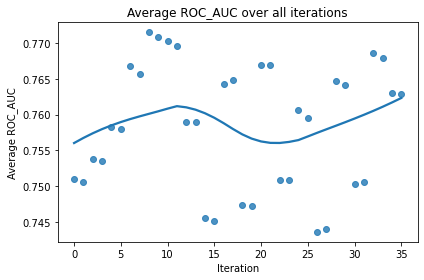

In [37]:
sns.regplot(x=np.arange(0, len(grid_search_parsed.results)), y=grid_search_parsed.results.sort_index()['ROC/AUC Mean'], lowess=True)
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()

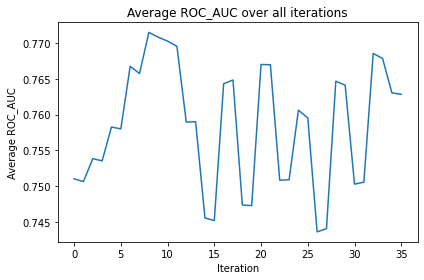

In [38]:
grid_search_parsed.results.sort_index()['ROC/AUC Mean'].plot()
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()